In [ ]:
"""
High-fidelity-ish PPG + blood-pressure fitting using JAX (GPU-enabled)

This script is a GPU-ready rewrite of the earlier CPU/scipy demo. It uses JAX for
JIT compilation and automatic differentiation, and jaxopt for optimization (L-BFGS).

Features:
- Ladder (multi-segment) transmission-like forward model implemented with jax.lax.scan
- JIT-compiled forward model and loss + gradient via JAX
- Optional estimation of Q_in from pressure/PPG peaks if Q_in not provided
- Parameter bounds via simple transform (softplus / sigmoid) to keep parameters positive
- CLI interface to run fit on a CSV file and save results

Expectations:
- Input CSV: columns `time, pressure, ppg` (optionally `q_in`). time in seconds, sampled at fs=125 Hz and length 1250.
- GPU: install jax with CUDA support appropriate for your system. See https://github.com/google/jax

Run example:
  python ppg_windkessel_jax_gpu.py --data ./mydata.csv --out results/ --nseg 12 --maxiter 200

Dependencies (install first):
  pip install --upgrade pip
  pip install jax jaxlib  # follow jax CUDA instructions for GPU build
  pip install jaxopt optax numpy pandas matplotlib scipy

Notes:
- This is intended as a practical, GPU-accelerated starting point for physics-based inversion.
- For large-scale research use: consider more accurate PDE solvers, adjoint-based continuous formulations, and hierarchical/Bayesian inference.

"""

import argparse
import os
from functools import partial

import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, grad, value_and_grad
from jax import lax

# jaxopt is nice for LBFGS; if missing, code falls back to a simple gradient-descent loop
try:
    from jaxopt import LBFGS
    _HAS_JAXOPT = True
except Exception:
    _HAS_JAXOPT = False

# -------------------- Utilities --------------------

def load_csv(path):
    df = pd.read_csv(path)
    required = ["time", "pressure", "ppg"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"CSV must contain columns: {required}")
    return df


def estimate_q_from_peaks_cpu(time, signal, fs, pulse_width=0.12, prominence=0.3):
    # Small CPU fallback peak-based Q estimator used before moving to JAX
    from scipy.signal import find_peaks
    sig = (signal - onp.min(signal))
    sig = sig / (onp.max(sig) + 1e-12)
    peaks, props = find_peaks(sig, prominence=prominence)
    t_peaks = time[peaks]
    Q = onp.zeros_like(time)
    sigma = pulse_width / 4.0
    for i, tp in enumerate(t_peaks):
        amp = sig[peaks[i]]
        Q += amp * onp.exp(-0.5 * ((time - (tp + 0.02)) / sigma) ** 2)
    Q *= 1.0 / (onp.trapz(Q, time) + 1e-12)
    return Q


# -------------------- JAX forward model --------------------
# We'll implement a ladder network via time-stepping using lax.scan.
# State variables per time step: P_nodes (Nseg), F_series (Nseg), P_term scalar

@jit
def ladder_step(carry, inputs):
    """
    carry: (P_prev, F_prev, P_term_prev)
    inputs: (Q_in_t, params)
    returns: new_carry, outputs
    outputs we want at each time: P_nodes, P_term, V_out
    """
    P_prev, F_prev, P_term_prev, params = carry
    Q_in_t = inputs
    # unpack params
    L_series = params['L_series']
    R_series = params['R_series']
    C_nodes = params['C_nodes']  # shape (Nseg,)
    C_term = params['C_term']
    R2 = params['R2']
    Nseg = C_nodes.shape[0]

    # update flows F: L dF/dt = P_i - P_{i+1} - R_series * F
    # we treat P_{Nseg} as P_term_prev
    P_extended = jnp.concatenate([P_prev, jnp.array([P_term_prev])], axis=0)

    def update_F_one(i, Fi):
        Pi = P_extended[i]
        Pi1 = P_extended[i+1]
        dFdt = (Pi - Pi1 - R_series * Fi) / (L_series + 1e-12)
        return Fi + dFdt * params['dt']

    # vectorized update
    dFdt_vec = (P_extended[:-1] - P_extended[1:] - R_series * F_prev) / (L_series + 1e-12)
    F_new = F_prev + dFdt_vec * params['dt']

    # update pressures: C dP/dt = F_prev_in - F_out
    F_in = Q_in_t
    # F_out for node i is F_new[i]
    F_prev_in_vec = jnp.concatenate([jnp.array([F_in]), F_new[:-1]], axis=0)
    dPdt = (F_prev_in_vec - F_new) / (C_nodes + 1e-12)
    P_new = P_prev + dPdt * params['dt']

    # update terminal pressure (simple RC outflow): C_term dP_term/dt = F_last - P_term/R2
    F_last = F_new[-1]
    dPterm_dt = (F_last - (P_term_prev / (R2 + 1e-12))) / (C_term + 1e-12)
    P_term_new = P_term_prev + dPterm_dt * params['dt']

    # output
    P_out = P_new[-1]
    V_out = C_nodes[-1] * P_out

    new_carry = (P_new, F_new, P_term_new, params)
    outputs = (P_new, P_term_new, P_out, V_out)
    return new_carry, outputs


def simulate_ladder_jax(Q_in, time, raw_params, Nseg=12):
    """
    Q_in: jnp array (T,)
    time: jnp array (T,)
    raw_params: dict with raw parameter values (unconstrained). We'll transform to physical values.
    returns dict of outputs (P_nodes: (T,Nseg), P_term: (T,), P_out: (T,), V_out: (T,))
    """
    dt = time[1] - time[0]
    T = Q_in.shape[0]

    # parameter transforms to ensure positivity where needed
    L_series = jnp.abs(raw_params['L_series']) + 1e-6
    R_series = jnp.abs(raw_params['R_series']) + 1e-6
    C0 = jnp.abs(raw_params['C0']) + 1e-6
    C_scale = jnp.exp(raw_params['log_C_scale'])  # positive
    C_nodes = C0 * C_scale * jnp.ones((Nseg,))
    C_term = jnp.abs(raw_params['C_term']) + 1e-6
    R2 = jnp.abs(raw_params['R2']) + 1e-6

    params = {
        'L_series': L_series,
        'R_series': R_series,
        'C_nodes': C_nodes,
        'C_term': C_term,
        'R2': R2,
        'dt': dt
    }

    # initial state zeros
    P0 = jnp.zeros((Nseg,))
    F0 = jnp.zeros((Nseg,))
    P_term0 = 0.0

    carry0 = (P0, F0, P_term0, params)

    # run scan
    # inputs sequence is Q_in (T,)
    def scan_fun(carry, Q_t):
        # carry includes params to be constant across steps
        carry2 = (carry[0], carry[1], carry[2], params)
        new_carry, outputs = ladder_step(carry2, Q_t)
        # new_carry already contains params; strip params for compactness
        P_new, F_new, P_term_new, _ = new_carry
        return (P_new, F_new, P_term_new, params), outputs

    # We'll use lax.scan where carry is (P,F,P_term,params)
    def body_func(carry, Q_t):
        P_prev, F_prev, P_term_prev, _ = carry
        new_carry, outputs = ladder_step((P_prev, F_prev, P_term_prev, params), Q_t)
        return new_carry, outputs

    final_carry, outputs = lax.scan(body_func, carry0, Q_in)
    # outputs is tuple of arrays with leading axis T
    P_nodes_seq, P_term_seq, P_out_seq, V_out_seq = outputs

    return {
        'P_nodes': P_nodes_seq,  # (T,Nseg)
        'P_term': P_term_seq,
        'P_out': P_out_seq,
        'V_out': V_out_seq
    }

# -------------------- Observation & loss --------------------

@jit
def observation_ppg_jax(V_local, a, b, tau, time):
    # a,b scalars; tau in seconds; time array
    # perform linear interpolation using jnp.interp
    time_shifted = time - tau
    ppg = a * jnp.interp(time, time_shifted, V_local, period=None) + b
    return ppg


@jit
def loss_fn(params_vec, time, Q_in, pressure_obs, ppg_obs, Nseg=12):
    """
    params_vec: 1D array containing stacked parameters in a fixed order
    Order: [L_series, R_series, C0, log_C_scale, C_term, R2, a, b, tau]
    """
    # unpack
    L_series = params_vec[0]
    R_series = params_vec[1]
    C0 = params_vec[2]
    log_C_scale = params_vec[3]
    C_term = params_vec[4]
    R2 = params_vec[5]
    a = params_vec[6]
    b = params_vec[7]
    tau = params_vec[8]

    raw = {
        'L_series': L_series,
        'R_series': R_series,
        'C0': C0,
        'log_C_scale': log_C_scale,
        'C_term': C_term,
        'R2': R2
    }

    sim = simulate_ladder_jax(Q_in, time, raw, Nseg=Nseg)
    P_model = sim['P_out']
    V_model = sim['V_out']

    # linear scaling of pressure to observed units: compute sP,oP via least squares closed form
    # solve [P_model, 1] [sP; oP] = pressure_obs
    # compute via normal equations (stable enough for jax here)
    A11 = jnp.dot(P_model, P_model) + 1e-8
    A12 = jnp.sum(P_model)
    A22 = P_model.shape[0]
    b1 = jnp.dot(P_model, pressure_obs)
    b2 = jnp.sum(pressure_obs)
    det = A11 * A22 - A12 * A12 + 1e-12
    sP = (b1 * A22 - b2 * A12) / det
    oP = (A11 * b2 - A12 * b1) / det

    P_model_scaled = sP * P_model + oP
    ppg_model = observation_ppg_jax(V_model, a, b, tau, time)

    # residuals
    resP = P_model_scaled - pressure_obs
    resPPG = ppg_model - ppg_obs

    # weights (normalize by std) to balance losses
    wP = 1.0 / (jnp.std(pressure_obs) + 1e-6)
    wPPG = 1.0 / (jnp.std(ppg_obs) + 1e-6)

    loss_val = jnp.mean((wP * resP) ** 2) + jnp.mean((wPPG * resPPG) ** 2)
    return loss_val


# -------------------- Optimization wrapper --------------------

def run_optimization_jax(time, Q_in, pressure_obs, ppg_obs, Nseg=12, maxiter=200):
    # initial parameter vector (in unconstrained paramization where appropriate)
    # We'll keep parameters in ranges reasonable for convergence; user tuning might be needed
    init = onp.array([
        0.02,  # L_series
        0.08,  # R_series
        0.8,   # C0
        onp.log(1.0),  # log_C_scale
        1.0,   # C_term
        0.6,   # R2
        0.8,   # a
        0.0,   # b
        0.01   # tau
    ], dtype=onp.float32)

    params0 = jnp.array(init)

    if _HAS_JAXOPT:
        solver = LBFGS(fun=lambda x: value_and_grad(loss_fn)(x, time, Q_in, pressure_obs, ppg_obs, Nseg),
                       maxiter=maxiter, tol=1e-6)
        # LBFGS expects initial params as jnp array
        state = solver.init_state(params0)
        params_opt, state = solver.run(params0, state)
        return params_opt
    else:
        # simple gradient descent loop (slow) as fallback
        params = params0
        lr = 1e-2
        for i in range(maxiter):
            loss_val, grads = value_and_grad(loss_fn)(params, time, Q_in, pressure_obs, ppg_obs, Nseg)
            params = params - lr * grads
            if i % 20 == 0:
                print(f"iter {i}, loss {loss_val:.6f}")
        return params


# -------------------- CLI & orchestrator --------------------

def run_pipeline(data_path, out_dir, nseg=12, maxiter=200, use_q_from_file=False):
    os.makedirs(out_dir, exist_ok=True)
    df = load_csv(data_path)
    time = df['time'].to_numpy().astype(onp.float32)
    pressure = df['pressure'].to_numpy().astype(onp.float32)
    ppg = df['ppg'].to_numpy().astype(onp.float32)

    # ensure shapes and dtypes for JAX
    time_j = jnp.array(time)
    pressure_j = jnp.array(pressure)
    ppg_j = jnp.array(ppg)

    if use_q_from_file and 'q_in' in df.columns:
        Q_in = df['q_in'].to_numpy().astype(onp.float32)
    else:
        print("Estimating Q_in from pressure peaks (CPU). For better results provide q_in measured or ECG-based estimate.")
        Q_est = estimate_q_from_peaks_cpu(time, pressure, fs=125, pulse_width=0.12, prominence=0.2)
        Q_in = Q_est.astype(onp.float32)

    Q_j = jnp.array(Q_in)

    print("Starting optimization on device:", jax.devices()[0])
    params_opt = run_optimization_jax(time_j, Q_j, pressure_j, ppg_j, Nseg=nseg, maxiter=maxiter)
    params_opt_np = onp.array(params_opt)

    # simulate final with optimal params
    raw = {
        'L_series': params_opt_np[0],
        'R_series': params_opt_np[1],
        'C0': params_opt_np[2],
        'log_C_scale': params_opt_np[3],
        'C_term': params_opt_np[4],
        'R2': params_opt_np[5]
    }
    sim = simulate_ladder_jax(Q_j, time_j, raw, Nseg=nseg)
    P_model = onp.array(sim['P_out'])
    V_model = onp.array(sim['V_out'])

    # compute final linear scale for pressure
    A11 = onp.dot(P_model, P_model) + 1e-8
    A12 = onp.sum(P_model)
    A22 = P_model.shape[0]
    b1 = onp.dot(P_model, pressure)
    b2 = onp.sum(pressure)
    det = A11 * A22 - A12 * A12 + 1e-12
    sP = (b1 * A22 - b2 * A12) / det
    oP = (A11 * b2 - A12 * b1) / det
    P_model_scaled = sP * P_model + oP

    # final ppg
    a_opt = params_opt_np[6]
    b_opt = params_opt_np[7]
    tau_opt = params_opt_np[8]
    # simple interpolation for final ppg
    ppg_model = a_opt * onp.interp(time, time - tau_opt, V_model) + b_opt

    # save results
    out_df = pd.DataFrame({
        'time': time,
        'q_in': Q_in,
        'pressure_obs': pressure,
        'pressure_model': P_model_scaled,
        'ppg_obs': ppg,
        'ppg_model': ppg_model
    })
    out_csv = os.path.join(out_dir, 'fit_result_jax.csv')
    out_df.to_csv(out_csv, index=False)

    # save params
    params_dict = {
        'L_series': float(params_opt_np[0]),
        'R_series': float(params_opt_np[1]),
        'C0': float(params_opt_np[2]),
        'C_scale': float(onp.exp(params_opt_np[3])),
        'C_term': float(params_opt_np[4]),
        'R2': float(params_opt_np[5]),
        'a': float(params_opt_np[6]),
        'b': float(params_opt_np[7]),
        'tau': float(params_opt_np[8])
    }
    pd.Series(params_dict).to_csv(os.path.join(out_dir, 'fitted_params.csv'))

    # compute RMSEs
    rmse_P = onp.sqrt(onp.mean((P_model_scaled - pressure) ** 2))
    rmse_PPG = onp.sqrt(onp.mean((ppg_model - ppg) ** 2))

    print(f"Finished. RMSE pressure: {rmse_P:.4f}, RMSE PPG: {rmse_PPG:.6f}")
    print("Saved results to", out_dir)

    # plot quick figures and save
    plt.figure(figsize=(10,7))
    plt.subplot(3,1,1)
    plt.plot(time, Q_in)
    plt.title('Q_in (used)')
    plt.subplot(3,1,2)
    plt.plot(time, pressure, label='obs')
    plt.plot(time, P_model_scaled, label='model', linewidth=1)
    plt.legend()
    plt.subplot(3,1,3)
    plt.plot(time, ppg, label='ppg_obs')
    plt.plot(time, ppg_model, label='ppg_model')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'fit_summary.png'))

    return params_dict, out_csv


if __name__ == '__main__':
    p = argparse.ArgumentParser()
    p.add_argument('--data', type=str, required=True, help='Path to CSV with time,pressure,ppg (and optional q_in)')
    p.add_argument('--out', type=str, required=True, help='Output directory')
    p.add_argument('--nseg', type=int, default=12, help='Number of ladder segments')
    p.add_argument('--maxiter', type=int, default=200, help='Max iterations for optimizer')
    p.add_argument('--use_q', action='store_true', help='Use q_in column from CSV if present')
    args = p.parse_args()

    params, out_csv = run_pipeline(args.data, args.out, nseg=args.nseg, maxiter=args.maxiter, use_q_from_file=args.use_q)
    print('Done. Params:', params)


## Wave instensity analysis

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
a = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_2.npy")
a.shape

(38110, 2, 1250)

In [6]:
subject = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_subjects_2.npy")
subject.shape

(38110,)

In [10]:
def align(ref, can, ref_sign, can_sign):
    """
    Function for aligning two signals.

    Args:
        ref (numpy_arr): normalized reference signal
        can (numpy_arr): normalized candidate signal
        ref_sign (numpy_arr): reference signal
        can_sign (numpy_arr): candidate signal

    Returns:
        _type_: 2 numpy arrays
    """
    corr = np.correlate(ref, can, mode="same")
    delay = np.argmax(corr) - (len(ref) // 2)
    if delay == 0:
        return ref_sign, can_sign
    elif delay > 0:
        return ref_sign[delay:], can_sign[:-delay]
    else:
        return ref_sign[:delay], can_sign[abs(delay) :]


In [35]:
def plot_signals(info_dict,signals,class_labels,sbp):
    fig, axes = plt.subplots(3,2, figsize=(10,8))
    axes[0,1].axis('off')
    plot_single_signal(axes[0,0],info_dict,signals,class_labels,sbp,reference=True)  
    plot_single_signal(axes[1,0],info_dict,signals,class_labels,sbp,reference=False,key="same_0")  
    plot_single_signal(axes[1,1],info_dict,signals,class_labels,sbp,reference=False,key="nosame_0")  
    plot_single_signal(axes[2,0],info_dict,signals,class_labels,sbp,reference=False,key="same_1")  
    plot_single_signal(axes[2,1],info_dict,signals,class_labels,sbp,reference=False,key="nosame_1") 
    plt.tight_layout()
    plt.show() 
    
def plot_single_signal(ax,info_dict,signals,class_labels,sbp,reference=True,key=None):
    
    if reference:
        ax.plot(signals[info_dict["reference_index"],1])
        title = f"Subject {info_dict['reference_subject']}, index {info_dict['reference_index']}, class {class_labels[info_dict['reference_index']]}, sbp {int(sbp[info_dict['reference_index']])}"
    else:
        if len(info_dict[key]) == 0:
            ax.axis('off')
            return
        rand_idx = np.random.randint(0, len(info_dict[key]))
        index, dist_ppg, dist_bp = info_dict[key][rand_idx]
        ax.plot(signals[index,1])
        title = f"index {index}, class {class_labels[index]}, sbp {int(sbp[index])}, dist_ppg {dist_ppg:.2f}, dist_bp {dist_bp:.2f}"
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("PPG Signal")
    ax.grid()

index: 30532 same subject: 355 class: 1 sbp: 182
same_0 0, 0.0% nosame_0 3, 0.8%
same_1 1, 0.3% nosame_1 351, 98.9%


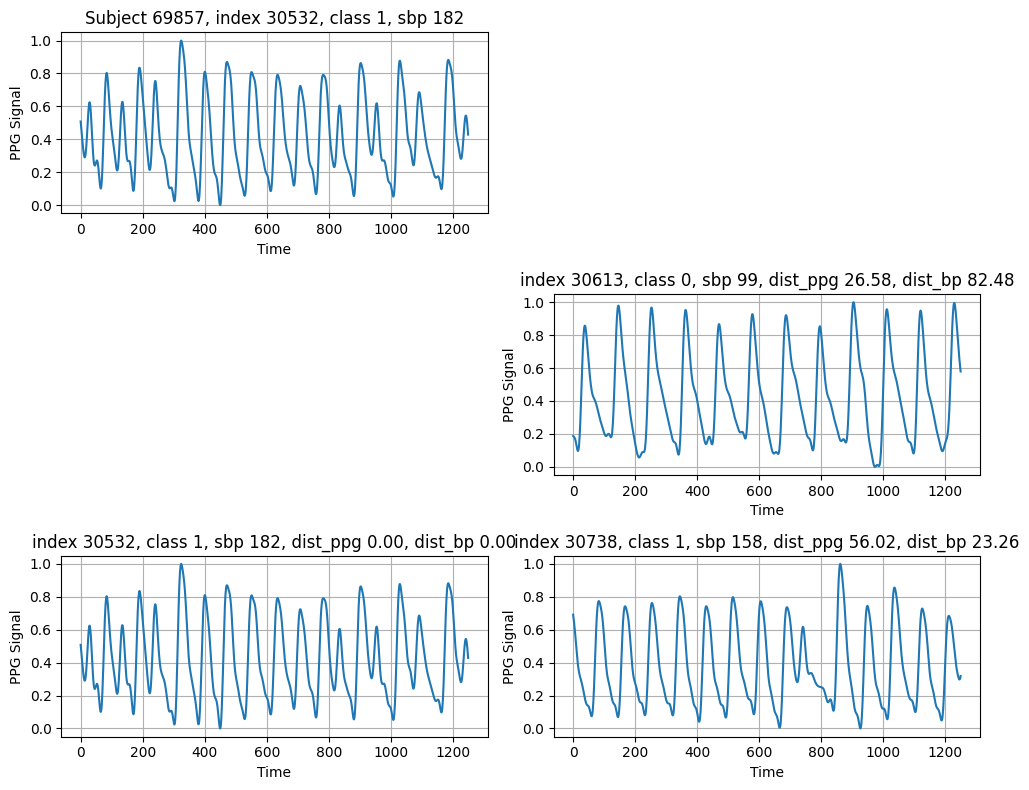

In [38]:
i = np.random.randint(0, a.shape[0])
reference = a[i]
same_subject_indices = np.where(subject == subject[i])[0]
class_labels = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_sbp_2labels.npy")
sbp = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_sbp_2.npy")
print("index:", i, "same subject:", len(same_subject_indices),"class:", class_labels[i], "sbp:", int(sbp[i]))
same_1 = []
nosame_1 = []
same_0 = []
nosame_0 = []
ppg_thresold = 5
sbp_threshold = 8
for idx in same_subject_indices:
    candidate = a[idx]
    ref,can = align(reference[:,1], candidate[:,1], reference[:,1], candidate[:,1],)
    distance_ppg = np.linalg.norm(ref-can)
    distance_bp = abs(sbp[i] - sbp[idx])
    close = distance_ppg < ppg_thresold and distance_bp < sbp_threshold
    if class_labels[idx] == 1:
        if close:
            same_1.append([idx, distance_ppg, distance_bp])
        else:
            nosame_1.append([idx, distance_ppg, distance_bp])
    else:
        if close:
            same_0.append([idx, distance_ppg, distance_bp])
        else:
            nosame_0.append([idx, distance_ppg, distance_bp])
print(f"same_0 {len(same_0)}, {len(same_0)/len(same_subject_indices)*100:.1f}% nosame_0 {len(nosame_0)}, {len(nosame_0)/len(same_subject_indices)*100:.1f}%")
print(f"same_1 {len(same_1)}, {len(same_1)/len(same_subject_indices)*100:.1f}% nosame_1 {len(nosame_1)}, {len(nosame_1)/len(same_subject_indices)*100:.1f}%")
info_dict = {
    "reference_subject": subject[i],
    "reference_index": i,
    "same_1": same_1,
    "nosame_1": nosame_1,
    "same_0": same_0,
    "nosame_0": nosame_0,
    "same_subject_indices": same_subject_indices,
}
plot_signals(info_dict,a,class_labels,sbp)

# 2-Element Windkessel model [Choudhury+, 2014, Wu+, 2023]

In [4]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
ppg = pd.read_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet")

In [104]:
random_idx = np.random.randint(0, ppg.shape[0])
target = ppg.iloc[random_idx]
print(i)
print(f"Td: {target['Td']:.2f}, Ts: {target['Ts']:.2f},Tc: {target['Tc']:.2f}")

30532
Td: 0.66, Ts: 0.35,Tc: 1.01


In [49]:
ppg.columns.tolist()

['Unnamed: 0',
 'Tc',
 'Ts',
 'Td',
 'Tsteepest',
 'Steepest',
 'TNegSteepest',
 'NegSteepest',
 'TdiaRise',
 'DiaRise',
 'SteepDiaRise',
 'TSystoDiaRise',
 'TdiaToEnd',
 'Ratio',
 'Ts_norm',
 'Td_norm',
 'Tsteepest_norm',
 'TNegSteepest_norm',
 'TdiaRise_norm',
 'TSystoDiaRise_norm',
 'TdiaToEnd_norm',
 'SW25',
 'SW25_norm',
 'DW25',
 'DW25_norm',
 'SWaddDW25',
 'SWaddDW25_norm',
 'DWdivSW25',
 'SW50',
 'SW50_norm',
 'DW50',
 'DW50_norm',
 'SWaddDW50',
 'SWaddDW50_norm',
 'DWdivSW50',
 'SW75',
 'SW75_norm',
 'DW75',
 'DW75_norm',
 'SWaddDW75',
 'SWaddDW75_norm',
 'DWdivSW75',
 'S1',
 'S2',
 'S3',
 'S4',
 'AUCsys',
 'AUCdia',
 'S1_norm',
 'S2_norm',
 'S3_norm',
 'S4_norm',
 'AUCsys_norm',
 'AUCdia_norm',
 'SQI_skew',
 'SQI_kurtosis',
 'apg_a',
 'apg_b',
 'apg_c',
 'apg_d',
 'apg_e',
 'ppg_a',
 'ppg_b',
 'ppg_c',
 'ppg_d',
 'ppg_e',
 'ratio_apg_b',
 'ratio_apg_c',
 'ratio_apg_d',
 'ratio_apg_e',
 'ratio_ppg_b',
 'ratio_ppg_c',
 'ratio_ppg_d',
 'ratio_ppg_e',
 'T_a',
 'T_b',
 'T_c',
 'T_

In [105]:
sbp = target['sbp']
dbp = target['dbp']

In [80]:
sbp

123.30138645576234

In [118]:
# Windkessel parameters (example values)    # mmHg·s/mL
# C = 1.5e-3    # mL/mmHg
Tc = target['Tc']     # cardiac cycle (s)
Ts = target['Ts']      # systolic duration (s)
Td = target['Td']      # diastolic duration (s)
Co = 5     # cardiac output (L/min)
# Compute I0 using equation (4)
integral_val = (2 * Ts) / np.pi   # ∫ sin(πt/Ts) dt = 2Ts/π
CoTc = Co*(Ts+Td)  # example cardiac output times Tc (arbitrary units)
I0 = CoTc / 60 / integral_val

# I(t) function
def I(t):
    t_mod = t % Tc
    if 0 < t_mod <= Ts:
        return I0 * np.sin(np.pi * t_mod / Ts)
    else:
        return 0.0
I_vector = np.vectorize(I)
Iw = I_vector(np.arange(0, 10.0, 0.0005))
# Simulate pressure using Euler method
def simulate_pressure(t_end=10.0, dt=0.0005):
    t = np.arange(0, t_end, dt)
    P = np.zeros_like(t)
    P[0] = 80.0
    for i in range(1, len(t)):
        It = I(t[i])
        dP = (It - P[i-1]/R) / C
        P[i] = P[i-1] + dP * dt
        print(f"t={t[i]:.4f}, P={P[i]:.2f} dP={dP:.4f}, I={It:.4f}")
    return t, P

t, P = simulate_pressure()


t=0.0005, P=79.96 dP=-74.2309, I=0.0017
t=0.0010, P=79.93 dP=-72.4916, I=0.0034
t=0.0015, P=79.89 dP=-70.7532, I=0.0051
t=0.0020, P=79.86 dP=-69.0157, I=0.0068
t=0.0025, P=79.82 dP=-67.2792, I=0.0085
t=0.0030, P=79.79 dP=-65.5437, I=0.0103
t=0.0035, P=79.76 dP=-63.8092, I=0.0120
t=0.0040, P=79.73 dP=-62.0758, I=0.0137
t=0.0045, P=79.70 dP=-60.3435, I=0.0154
t=0.0050, P=79.67 dP=-58.6123, I=0.0171
t=0.0055, P=79.64 dP=-56.8823, I=0.0188
t=0.0060, P=79.61 dP=-55.1535, I=0.0205
t=0.0065, P=79.59 dP=-53.4259, I=0.0222
t=0.0070, P=79.56 dP=-51.6996, I=0.0239
t=0.0075, P=79.53 dP=-49.9746, I=0.0256
t=0.0080, P=79.51 dP=-48.2510, I=0.0273
t=0.0085, P=79.49 dP=-46.5287, I=0.0290
t=0.0090, P=79.46 dP=-44.8078, I=0.0307
t=0.0095, P=79.44 dP=-43.0883, I=0.0324
t=0.0100, P=79.42 dP=-41.3704, I=0.0341
t=0.0105, P=79.40 dP=-39.6539, I=0.0358
t=0.0110, P=79.38 dP=-37.9390, I=0.0375
t=0.0115, P=79.37 dP=-36.2256, I=0.0392
t=0.0120, P=79.35 dP=-34.5139, I=0.0409
t=0.0125, P=79.33 dP=-32.8038, I=0.0426


In [107]:
I0

0.3790080422857585

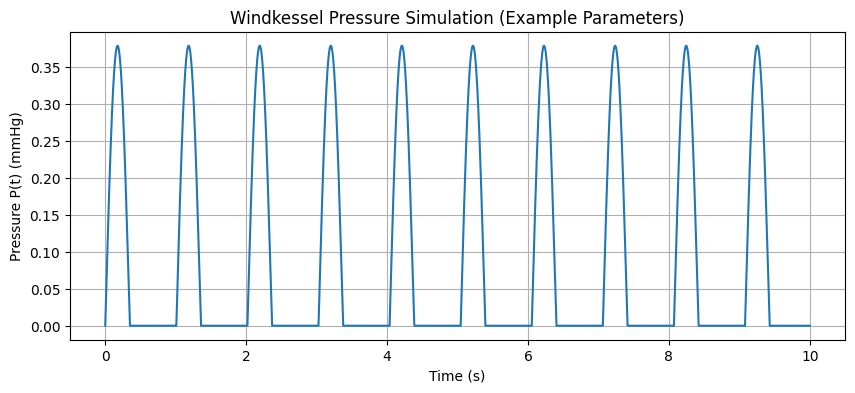

In [119]:
# Plot
plt.figure(figsize=(10,4))
plt.plot(t, Iw)
plt.title("Windkessel Pressure Simulation (Example Parameters)")
plt.xlabel("Time (s)")
plt.ylabel("Pressure P(t) (mmHg)")
plt.grid()
plt.show()

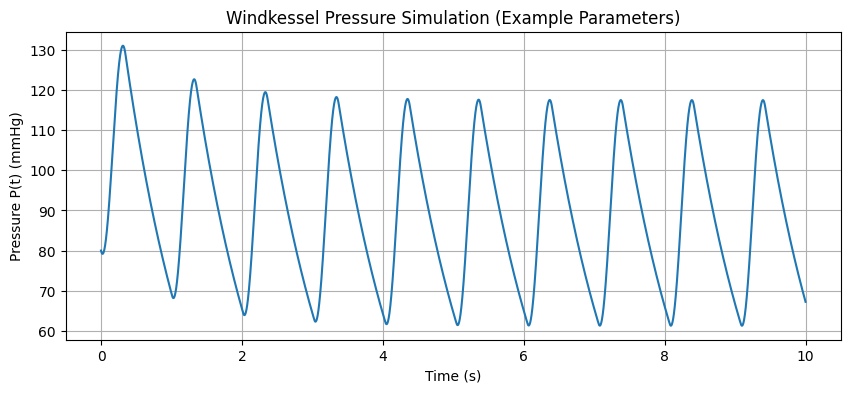

In [120]:
plt.figure(figsize=(10,4))
plt.plot(t, P)
plt.title("Windkessel Pressure Simulation (Example Parameters)")
plt.xlabel("Time (s)")
plt.ylabel("Pressure P(t) (mmHg)")
plt.grid()
plt.show()

In [ ]:
def dPdt(t, P):
    return (I(t) - R*P) / C

In [112]:
from scipy.integrate import solve_ivp
P0 = [80.0]
t_span = (0, 5)  # 0～5秒
t_eval = np.linspace(t_span[0], t_span[1], 500)

# 数値解
sol = solve_ivp(dPdt, t_span, P0, t_eval=t_eval, method='RK45')

KeyboardInterrupt: 

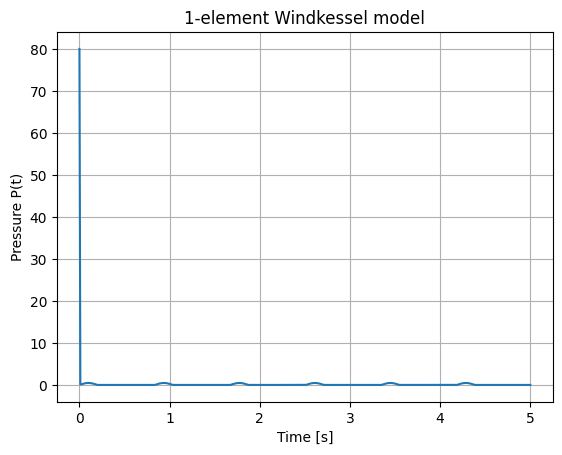

In [113]:
plt.plot(sol.t, sol.y[0])
plt.xlabel("Time [s]")
plt.ylabel("Pressure P(t)")
plt.title("1-element Windkessel model")
plt.grid(True)
plt.show()

In [68]:
# Pts = 80
# Ptd = 


# Equation (5)
def Ps(Ts, Pts, R, C, I0):
    return Pts*np.exp(-Ts/(R*C)) + (I0*Ts*C*np.pi*(R**2))/(Ts**2 + (C*np.pi*R)**2) * (1 + np.exp(-Ts/(R*C)))
# Ps = Pts*np.exp(-Ts/(R*C)) + (I0*Ts*C*np.pi*(R**2))/(Ts**2 + (C*np.pi*R)**2) * (1 + np.exp(-Ts/(R*C)))
# Equation (6)
def Pd(Td, Pts, R, C):
    return Pts*np.exp(-Td/(R*C))

# Pd = Ptd*np.exp(-Td/(R*C))

In [ ]:
from scipy.optimize import fsolve
def equations(vars):
    R, C = vars
    RC = R*C
    expTs = np.exp(-Ts/(R*C))
    A = (Ps - Pts * expTs) / (1 + expTs)
    eq1 = R**2 - (A * Ts**2) / (np.pi * C * (I0*Ts - np.pi * C * A))
    eq2 = R * C - RC  # RCの関係
    return [eq1, eq2]

# 初期値の推定
R0 = 1.0
C0 = 1.0

R, C = fsolve(equations, [R0, C0])

print(f"R = {R:.4f}")
print(f"C = {C:.4f}")

1. Pts = 80 を(5)Ptsに代入 -> Ps
2. Psを (6)Ptdに代入-> Pd
3. Pdを (Pts)に代入 -> Ps  
続く

L0  2 is initially calculated using (6) with Ptd and Pd set to the measured SBP and DBP 　
L0  1 is derived with (5) with Pts and Ps set to the measured DBP and SBP

In [81]:
sbp,dbp

(123.30138645576234, 76.0277487002395)

In [ ]:


# L1 = I0*R
# L2 = R*C
# Ps_ = Pts*np.exp(-Ts/L2) + (L1*L2*Ts*np.pi)/(Ts**2 + (L1*np.pi)**2) * (1 + np.exp(-Ts/L2))
# Pd_ = Ptd*np.exp(-Td/L2)
# Ps = Pts*np.exp(-Ts/L2) + (L1*L2*Ts*np.pi)/(Ts**2 + (L2*np.pi)**2) * (1 + np.exp(-Ts/L2))
# sbp = dbp*np.exp(-Td/L2)
L_02 = -Td/np.log(dbp/sbp)
E = np.exp(-Ts / L_02)
L_01 = (sbp-dbp*E)*(Ts**2 + (L_02*np.pi)**2)/(L_02*Ts*np.pi*(1+E))
print("L_02:", L_02)
print("L_01:", L_01)
print((sbp-dbp*E), (Ts**2 + (L_02*np.pi)**2), (L_02*Ts*np.pi*(1+E)))

NameError: name 'Td' is not defined

In [85]:
L_02

1.3250945013425808

In [122]:
R = L_01 / I0
C = L_02 / R
print("R:", R)
print("C:", C)

R: 1050.774443765431
C: 0.0010026250672142433


In [7]:
ppg['L_02'] =  ppg['Td'] / -np.log(ppg['dbp']/ppg['sbp'])
ppg['L_01'] = (ppg['sbp']-ppg['dbp']*np.exp(-ppg['Ts'] / ppg['L_02']))*(ppg['Ts']**2 + (ppg['L_02']*np.pi)**2)/(ppg['L_02']*ppg['Ts']*np.pi*(1+np.exp(-ppg['Ts'] / ppg['L_02'])))

In [124]:
ppg.columns.tolist()

['Unnamed: 0',
 'Tc',
 'Ts',
 'Td',
 'Tsteepest',
 'Steepest',
 'TNegSteepest',
 'NegSteepest',
 'TdiaRise',
 'DiaRise',
 'SteepDiaRise',
 'TSystoDiaRise',
 'TdiaToEnd',
 'Ratio',
 'Ts_norm',
 'Td_norm',
 'Tsteepest_norm',
 'TNegSteepest_norm',
 'TdiaRise_norm',
 'TSystoDiaRise_norm',
 'TdiaToEnd_norm',
 'SW25',
 'SW25_norm',
 'DW25',
 'DW25_norm',
 'SWaddDW25',
 'SWaddDW25_norm',
 'DWdivSW25',
 'SW50',
 'SW50_norm',
 'DW50',
 'DW50_norm',
 'SWaddDW50',
 'SWaddDW50_norm',
 'DWdivSW50',
 'SW75',
 'SW75_norm',
 'DW75',
 'DW75_norm',
 'SWaddDW75',
 'SWaddDW75_norm',
 'DWdivSW75',
 'S1',
 'S2',
 'S3',
 'S4',
 'AUCsys',
 'AUCdia',
 'S1_norm',
 'S2_norm',
 'S3_norm',
 'S4_norm',
 'AUCsys_norm',
 'AUCdia_norm',
 'SQI_skew',
 'SQI_kurtosis',
 'apg_a',
 'apg_b',
 'apg_c',
 'apg_d',
 'apg_e',
 'ppg_a',
 'ppg_b',
 'ppg_c',
 'ppg_d',
 'ppg_e',
 'ratio_apg_b',
 'ratio_apg_c',
 'ratio_apg_d',
 'ratio_apg_e',
 'ratio_ppg_b',
 'ratio_ppg_c',
 'ratio_ppg_d',
 'ratio_ppg_e',
 'T_a',
 'T_b',
 'T_c',
 'T_

In [ ]:
# import groupKfold and svr
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
models = []
train_idxs = []
test_idxs = []
predictions = []
for train_idx, test_idx in GroupKFold(n_splits=5).split(ppg, groups=ppg['subject']):
    X_train = ppg.iloc[train_idx].drop(["Unnamed: 0","L_01","L_02","subject","signal_index","sbp","dbp"], axis=1, errors='ignore')
    y_train1 = ppg.iloc[train_idx]['L_01']
    y_train2 = ppg.iloc[train_idx]['L_02']
    
    X_test = ppg.iloc[test_idx].drop(["Unnamed: 0","L_01","L_02","subject","signal_index","sbp","dbp"], axis=1, errors='ignore')
    
    y_test1 = ppg.iloc[test_idx]['L_01']
    y_test2 = ppg.iloc[test_idx]['L_02']
    lgb1  = lgb.LGBMRegressor(n_estimators=1000)
    lgb2  = lgb.LGBMRegressor(n_estimators=1000)
    lgb1.fit(X_train, y_train1)
    lgb2.fit(X_train, y_train2)
    
    y_pred1 = lgb1.predict(X_test)
    y_pred2 = lgb2.predict(X_test)
    
    mae1 = mean_absolute_error(y_test1, y_pred1)
    mae2 = mean_absolute_error(y_test2, y_pred2)
    models.append((lgb1, lgb2))
    train_idxs.append(train_idx)
    test_idxs.append(test_idx)
    predictions.append(np.array([y_pred1, y_pred2]))
    print(f"MAE L_01: {mae1:.2f}, MAE L_02: {mae2:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24990
[LightGBM] [Info] Number of data points in the train set: 72213, number of used features: 98
[LightGBM] [Info] Start training from score 532.217729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24990
[LightGBM] [Info] Number of data points in the train set: 72213, number of used features: 98
[LightGBM] [Info] Start training from score 0.944690
MAE L_01: 61.88, MAE L_02: 0.19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24990
[LightGBM] [Info] Number of data points in the train set: 72227, number of used fea

In [21]:
[print(a.shape) for a in predictions]

(2, 18076)
(2, 18062)
(2, 18048)
(2, 18033)
(2, 18070)


[None, None, None, None, None]

### get pred bp

In [23]:
preds = predictions[0]
print(preds.shape)
L_2 = preds[1].flatten()
L_1 = preds[0].flatten()
bps = np.zeros((2,10+1,preds.shape[1]))
bps[0,0,:] = 80.0
for i in range(10):
    Pts = bps[0,i,:]
    Td = ppg.iloc[test_idxs[0]]['Td'].to_numpy()
    Ts = ppg.iloc[test_idxs[0]]['Ts'].to_numpy()
    Ps = Pts*np.exp(-Ts/L_2) + (L_1*L_2*Ts*np.pi)/(Ts**2 + (L_2*np.pi)**2) * (1 + np.exp(-Ts/L_2))
    bps[1,i,:] = Ps
    Ptd = Ps*np.exp(-Td/L_2)
 
    bps[0,i+1,:] = Ptd
# bps 
# Pd = Pts*np.exp(-Td/L_2)
# Ps = Pts*np.exp(-Ts/L_2) + (L_1*L_2*Ts*np.pi)/(Ts**2 + (L_2*np.pi)**2) * (1 + np.exp(-Ts/L_2))


(2, 18076)


In [25]:
bps[:,-2,:].shape,bps[:,-2,:]

((2, 18076),
 array([[ 62.64334158,  49.11070219,  66.0748612 , ...,  72.15486595,
          60.72456014,  66.51321095],
        [119.56549349,  91.57667194, 116.05123175, ..., 132.21743764,
         114.03645404, 114.95179275]]))

In [26]:
sbp_pred = bps[1,-2,:]
dbp_pred = bps[0,-1,:]
mae_sbp = mean_absolute_error(ppg.iloc[test_idxs[0]]['sbp'], sbp_pred)
mae_dbp = mean_absolute_error(ppg.iloc[test_idxs[0]]['dbp'], dbp_pred)
print(f"MAE SBP: {mae_sbp:.2f}, MAE DBP: {mae_dbp:.2f}")

MAE SBP: 15.09, MAE DBP: 9.01


In [11]:
 ppg.iloc[train_idx].drop(["Unnamed: 0","L_01","L_02","subject","signal_index","sbp","dbp"], axis=1, errors='ignore').columns.tolist()

['Tc',
 'Ts',
 'Td',
 'Tsteepest',
 'Steepest',
 'TNegSteepest',
 'NegSteepest',
 'TdiaRise',
 'DiaRise',
 'SteepDiaRise',
 'TSystoDiaRise',
 'TdiaToEnd',
 'Ratio',
 'Ts_norm',
 'Td_norm',
 'Tsteepest_norm',
 'TNegSteepest_norm',
 'TdiaRise_norm',
 'TSystoDiaRise_norm',
 'TdiaToEnd_norm',
 'SW25',
 'SW25_norm',
 'DW25',
 'DW25_norm',
 'SWaddDW25',
 'SWaddDW25_norm',
 'DWdivSW25',
 'SW50',
 'SW50_norm',
 'DW50',
 'DW50_norm',
 'SWaddDW50',
 'SWaddDW50_norm',
 'DWdivSW50',
 'SW75',
 'SW75_norm',
 'DW75',
 'DW75_norm',
 'SWaddDW75',
 'SWaddDW75_norm',
 'DWdivSW75',
 'S1',
 'S2',
 'S3',
 'S4',
 'AUCsys',
 'AUCdia',
 'S1_norm',
 'S2_norm',
 'S3_norm',
 'S4_norm',
 'AUCsys_norm',
 'AUCdia_norm',
 'SQI_skew',
 'SQI_kurtosis',
 'apg_a',
 'apg_b',
 'apg_c',
 'apg_d',
 'apg_e',
 'ppg_a',
 'ppg_b',
 'ppg_c',
 'ppg_d',
 'ppg_e',
 'ratio_apg_b',
 'ratio_apg_c',
 'ratio_apg_d',
 'ratio_apg_e',
 'ratio_ppg_b',
 'ratio_ppg_c',
 'ratio_ppg_d',
 'ratio_ppg_e',
 'T_a',
 'T_b',
 'T_c',
 'T_d',
 'T_e',
 'T

## 本番

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score   

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GroupKFold

In [28]:
train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet')
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
train_df=train_df.drop('Unnamed: 0', axis=1, errors='ignore')
test_df=test_df.drop('Unnamed: 0', axis=1, errors='ignore')  
train_df.shape, test_df.shape

((448377, 103), (54892, 103))

In [33]:
train_df['L_02'] =  train_df['Td'] / -np.log(train_df['dbp']/train_df['sbp'])
train_df['L_01'] = (train_df['sbp']-train_df['dbp']*np.exp(-train_df['Ts'] / train_df['L_02']))*(train_df['Ts']**2 + (train_df['L_02']*np.pi)**2)/(train_df['L_02']*train_df['Ts']*np.pi*(1+np.exp(-train_df['Ts'] / train_df['L_02'])))
test_df['L_02'] =  test_df['Td'] / -np.log(test_df['dbp']/test_df['sbp'])
test_df['L_01'] = (test_df['sbp']-test_df['dbp']*np.exp(-test_df['Ts'] / test_df['L_02']))*(test_df['Ts']**2 + (test_df['L_02']*np.pi)**2)/(test_df['L_02']*test_df['Ts']*np.pi*(1+np.exp(-test_df['Ts'] / test_df['L_02'])))

In [44]:
X_test = test_df.drop(["L_01","L_02","subject","signal_index","sbp","dbp","sbp_bin"], axis=1, errors='ignore')
y_test1 = test_df['L_01']
y_test2 = test_df['L_02']
y_test3 = test_df['sbp']
y_test4 = test_df['dbp']
X_test.shape, y_test1.shape, y_test2.shape

((54892, 98), (54892,), (54892,))

In [39]:
extra_cols = X_test.columns.difference(X_train.columns)
extra_cols

Index(['sbp_bin'], dtype='object')

In [46]:
params = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.01
    }

In [48]:
from sklearn.preprocessing import StandardScaler
for train_idx, val_idx in GroupKFold(n_splits=5).split(ppg, groups=ppg['subject']):
    X_train = ppg.iloc[train_idx].drop(["Unnamed: 0","L_01","L_02","subject","signal_index","sbp","dbp","sbp_bin"], axis=1, errors='ignore')
    y_train1 = ppg.iloc[train_idx]['L_01']
    y_train2 = ppg.iloc[train_idx]['L_02']
    y_train3 = ppg.iloc[train_idx]['sbp']
    y_train4 = ppg.iloc[train_idx]['dbp']
    X_val = ppg.iloc[val_idx].drop(["Unnamed: 0","L_01","L_02","subject","signal_index","sbp","dbp","sbp_bin"], axis=1, errors='ignore')
    y_val1 = ppg.iloc[val_idx]['L_01']
    y_val2 = ppg.iloc[val_idx]['L_02']
    y_val3 = ppg.iloc[val_idx]['sbp']
    y_val4 = ppg.iloc[val_idx]['dbp']
    print(X_train.shape, X_val.shape, y_train1.shape, y_val1.shape, y_train2.shape, y_val2.shape)
    regr1 = lgb.LGBMRegressor(**params)
    regr2 = lgb.LGBMRegressor(**params)
    regr3 = lgb.LGBMRegressor(**params)
    regr4 = lgb.LGBMRegressor(**params)
    regr1.fit(X_train, y_train1,callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=300)],eval_set=[(X_val,y_val1)],eval_metric="mae")
    regr2.fit(X_train, y_train2,callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=300)],eval_set=[(X_val,y_val2)],eval_metric="mae")
    regr3.fit(X_train.drop(["L_01","L_02"], axis=1, errors='ignore'), y_train3,callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=300)],eval_set=[(X_val.drop(["L_01","L_02"], axis=1, errors='ignore'),y_val3)],eval_metric="mae")
    regr4.fit(X_train.drop(["L_01","L_02"], axis=1, errors='ignore'), y_train4,callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=300)],eval_set=[(X_val.drop(["L_01","L_02"], axis=1, errors='ignore'),y_val4)],eval_metric="mae")
    L_1 = regr1.predict(X_test)
    L_2 = regr2.predict(X_test)
    l_mse = np.mean((L_1 - y_test1.to_numpy())**2 + (L_2 - y_test2.to_numpy())**2)
    l_mae = np.mean(np.abs(L_1 - y_test1.to_numpy()) + np.abs(L_2 - y_test2.to_numpy()))
    l_me = np.mean(L_1 - y_test1.to_numpy() + L_2 - y_test2.to_numpy())
    l_std = np.std((L_1 - y_test1.to_numpy()) + (L_2 - y_test2.to_numpy()))
    print("Error on latent parameters:")
    print(f"MSE: {l_mse:.4f}, MAE: {l_mae:.4f}, ME: {l_me:.4f}, STD: {l_std:.4f}")
    bps = np.zeros((2,10+1,L_1.shape[0]))
    bps[0,0,:] = 80.0
    for i in range(10):
        Pts = bps[0,i,:]
        Td = test_df['Td'].to_numpy()
        Ts = test_df['Ts'].to_numpy()
        Ps = Pts*np.exp(-Ts/L_2) + (L_1*L_2*Ts*np.pi)/(Ts**2 + (L_2*np.pi)**2) * (1 + np.exp(-Ts/L_2))
        bps[1,i,:] = Ps
        Ptd = Ps*np.exp(-Td/L_2)
        bps[0,i+1,:] = Ptd
    sbp_pred = bps[1,-2,:]
    dbp_pred = bps[0,-1,:]
    mae_sbp = mean_absolute_error(test_df['sbp'], sbp_pred)
    mae_dbp = mean_absolute_error(test_df['dbp'], dbp_pred)
    mean_sbp = np.mean(sbp_pred - test_df['sbp'])
    mean_dbp = np.mean(dbp_pred - test_df['dbp'])
    std_sbp = np.std(sbp_pred - test_df['sbp'])
    std_dbp = np.std(dbp_pred - test_df['dbp'])
    sbp_pred_ = regr3.predict(X_test.drop(["L_01","L_02"], axis=1, errors='ignore'))
    dbp_pred_ = regr4.predict(X_test.drop(["L_01","L_02"], axis=1, errors='ignore'))
    mae_sbp_ = mean_absolute_error(test_df['sbp'], sbp_pred_)
    mae_dbp_ = mean_absolute_error(test_df['dbp'], dbp_pred_)
    mean_sbp_ = np.mean(sbp_pred_ - test_df['sbp'])
    mean_dbp_ = np.mean(dbp_pred_ - test_df['dbp'])
    std_sbp_ = np.std(sbp_pred_ - test_df['sbp'])
    std_dbp_ = np.std(dbp_pred_ - test_df['dbp'])
    print("Error on blood pressure:")
    print(f"MAE SBP: {mae_sbp:.4f}, MAE DBP: {mae_dbp:.4f}",
          f"ME SBP: {mean_sbp:.4f}, ME DBP: {mean_dbp:.4f}",
          f"STD SBP: {std_sbp:.4f}, STD DBP: {std_dbp:.4f}")    
    print(f"MAE SBP direct: {mae_sbp_:.4f}, MAE DBP direct: {mae_dbp_:.4f}",
          f"ME SBP direct: {mean_sbp_:.4f}, ME DBP direct: {mean_dbp_:.4f}",
          f"STD SBP direct: {std_sbp_:.4f}, STD DBP direct: {std_dbp_:.4f}")

(72213, 98) (18076, 98) (72213,) (18076,) (72213,) (18076,)
Training until validation scores don't improve for 50 rounds
[300]	valid_0's l1: 59.4164
Early stopping, best iteration is:
[327]	valid_0's l1: 59.3281
Training until validation scores don't improve for 50 rounds
[300]	valid_0's l1: 0.175921
Early stopping, best iteration is:
[372]	valid_0's l1: 0.175409
Training until validation scores don't improve for 50 rounds
[300]	valid_0's l1: 14.173
Early stopping, best iteration is:
[263]	valid_0's l1: 14.1474
Training until validation scores don't improve for 50 rounds
[300]	valid_0's l1: 8.28395
Early stopping, best iteration is:
[276]	valid_0's l1: 8.28036
Error on latent parameters:
MSE: 6064.0461, MAE: 61.8430, ME: -6.8615, STD: 77.5749
Error on blood pressure:
MAE SBP: 15.2574, MAE DBP: 8.4552 ME SBP: -2.8864, ME DBP: 0.6257 STD SBP: 18.8479, STD DBP: 10.6331
MAE SBP direct: 14.9273, MAE DBP direct: 8.2006 ME SBP direct: -1.7494, ME DBP direct: -0.6913 STD SBP direct: 18.5421, S